# Results, section 1:

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_long/code/func/')
from proj_environment import set_proj_env
from func import get_fdr_p, get_cmap

In [3]:
exclude_str = 't1Exclude'
primary_covariate = 'scanageYears'
parc_scale = 400
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, primary_covariate = primary_covariate,
                                                                                       parc_scale = parc_scale)

In [4]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_long/analysis/normative/t1Exclude/schaefer_400/scanageYears+sex_adj'

## Load data

In [5]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid', 'timepoint'], inplace = True)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid', 'timepoint'], inplace = True)

# Test
df_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df_test.set_index(['bblid', 'scanid', 'timepoint'], inplace = True)
df_node_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid', 'timepoint'], inplace = True)

# concat
df = pd.concat((df_train, df_test), axis = 0); print(df.shape)
df_node = pd.concat((df_node_train, df_node_test), axis = 0); print(df_node.shape)

(2305, 17)
(2305, 800)


In [6]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

In [7]:
smse_thresh = 1

## Load nispat outputs

In [8]:
# Forward model
synth_cov_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'forward/synth_cov_test.txt'),
                             delim_whitespace = True, names=[primary_covariate, 'sex_adj'])

yhat_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/yhat.txt'), delimiter = ' ').transpose()
df_yhat_forward = pd.DataFrame(data = yhat_forward, index = synth_cov_test.index, columns = df_node.columns)

ys2_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/ys2.txt'), delimiter = ' ').transpose()
df_ys2_forward = pd.DataFrame(data = ys2_forward, index = synth_cov_test.index, columns = df_node.columns)

In [9]:
df_yhat_forward_tmp = df_yhat_forward + (df_yhat_forward.abs().max()+1)
print((df_yhat_forward_tmp<0).any().any())

annualized = True
if annualized:
    elapsed_time = synth_cov_test.loc[synth_cov_test['sex_adj'] == 0,primary_covariate].iloc[-1] - synth_cov_test.loc[synth_cov_test['sex_adj'] == 0,primary_covariate].iloc[0]
    print(elapsed_time)
    x = (df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[0,:]) - 1
    df_yhat_tmp1 = (np.power(1+x.abs(),1/elapsed_time)-1)*100
    df_yhat_tmp1[x<0] = df_yhat_tmp1[x<0]*-1

    x = (df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[0,:]) - 1
    df_yhat_tmp2 = (np.power(1+x.abs(),1/elapsed_time)-1)*100
    df_yhat_tmp2[x<0] = df_yhat_tmp2[x<0]*-1
else:
    df_yhat_tmp1 = ((df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[0,:]) - 1) * 100
    df_yhat_tmp2 = ((df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[0,:]) - 1) * 100

df_yhat_diff = pd.concat((df_yhat_tmp1, df_yhat_tmp2), axis = 1)
df_yhat_diff.head()

False
18.0


,0,1
ct_0,-0.357453,-0.358161
ct_1,-0.438650,-0.440874
ct_2,-0.433085,-0.400816
ct_3,-0.561717,-0.563027
ct_4,-0.151805,-0.078454


In [10]:
df_yhat_diff.filter(regex = 'ct', axis = 0).abs().max()

0    0.771389
1    0.774970
dtype: float64

In [11]:
df_yhat_diff.filter(regex = 'vol', axis = 0).abs().max()

0    0.759679
1    0.810540
dtype: float64

# Plots

In [12]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

metrics = ['ct', 'vol']
metrics_label_short = ['Thickness', 'Volume']
metrics_label = ['Thickness', 'Volume']
print(metrics)

['ct', 'vol']


## Brain plots nispat

In [13]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

In [14]:
subject_id = 'fsaverage'

In [15]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/opt/anaconda3/envs/neurodev_long/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['get_cmap']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0 = Male, 1 = Female

In [16]:
for metric in metrics:
    for hemi in ('lh', 'rh'):
        for sx in ('sex0','sex1'):
            # Plots of age correlation
            fig_str = hemi + '_' + metric + '_age_' + sx + '_frwd'
            if sx == 'sex0':
                roi_data = df_yhat_diff.loc[:,0].filter(regex = metric, axis = 0).values
            elif sx == 'sex1':
                roi_data = df_yhat_diff.loc[:,1].filter(regex = metric, axis = 0).values
#             age_filt = df_age_effect.filter(regex = metric, axis = 0)['p_fdr'] < age_alpha
#             smse_filt = df_smse.filter(regex = metric, axis = 0).loc[:,0] < smse_thresh
#             region_filt = np.logical_and(age_filt,smse_filt)
            region_filt = df_smse.filter(regex = metric, axis = 0).loc[:,0] < smse_thresh

            roi_data[~region_filt] = -1000
            center_anchor = 1

            if region_filt.any():
                if subject_id == 'lausanne125':
                    parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
                elif subject_id == 'fsaverage':
                    parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                             hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

                brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, color = 'coolwarm', center_anchor = center_anchor)
            else:
                print('Nothing significant')

1
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
1
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
1
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
1
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
1
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
1
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
1
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00

# Figures

In [17]:
%matplotlib inline

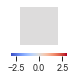

In [18]:
f, ax = plt.subplots(1)
f.set_figwidth(1)
f.set_figheight(1)

limit = 3
sns.heatmap(np.zeros((1,1)), annot = False, xticklabels = [""], yticklabels = [""], center = 0, vmax = limit, vmin = -limit, ax = ax, square = True, cmap = 'coolwarm', cbar_kws={"orientation": "horizontal"})
f.savefig('colorbar_'+str(limit)+'.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

Figure 2C (top)

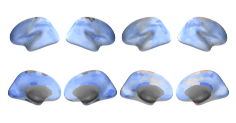

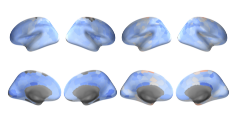

In [19]:
for my_str in ('_sex0_frwd', '_sex1_frwd'):
    # Age effects
    f, axes = plt.subplots(2, 4)
    f.set_figwidth(4)
    f.set_figheight(2)
    plt.subplots_adjust(wspace=0, hspace=0)


    # column 0:
    fig_str = 'lh_ct_age'+my_str+'.png'
    try:
#         axes[0,0].set_title('Thickness (L)', fontsize = 8)
        image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
    except FileNotFoundError: axes[0,0].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
    except FileNotFoundError: axes[1,0].axis('off')

    # column 1:
    fig_str = 'rh_ct_age'+my_str+'.png'
    try:
#         axes[0,1].set_title('Thickness (R)', fontsize = 8)
        image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
    except FileNotFoundError: axes[0,1].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
    except FileNotFoundError: axes[1,1].axis('off')

    # column 2:
    fig_str = 'lh_vol_age'+my_str+'.png'
    try:
#         axes[0,2].set_title('Jacobian (L)', fontsize = 8)
        image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
    except FileNotFoundError: axes[0,2].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
    except FileNotFoundError: axes[1,2].axis('off')

    # column 3:
    fig_str = 'rh_vol_age'+my_str+'.png'
    try:
#         axes[0,3].set_title('Jacobian (R)', fontsize = 8)
        image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
    except FileNotFoundError: axes[0,3].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
    except FileNotFoundError: axes[1,3].axis('off')

    plt.show()
    f.savefig('brain_age'+my_str+'.svg', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)
#     f.savefig('brain_age'+my_str+'.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)